In [64]:
from transformers import CLIPProcessor, CLIPModel
from datasets import load_dataset
from torch.utils.data import DataLoader
import torch
from torch import nn
from torch.optim import AdamW
import torch
import time
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score
from torch.nn.utils import clip_grad_norm_
from sklearn.metrics import accuracy_score

# Load pretrained CLIP
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").cuda()
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")



In [65]:
# Load MIMIC-CXR dataset
train_dataset = load_dataset("itsanmolgupta/mimic-cxr-dataset", split="train[:90%]")  
val_datset = load_dataset("itsanmolgupta/mimic-cxr-dataset", split="train[:10%]")
train_dataset = train_dataset.filter(lambda x: x['impression'] is not None)
val_dataset = val_datset.filter(lambda x: x['impression'] is not None)

In [66]:
train_dataset

Dataset({
    features: ['image', 'findings', 'impression'],
    num_rows: 27561
})

In [67]:
val_dataset

Dataset({
    features: ['image', 'findings', 'impression'],
    num_rows: 3062
})

In [68]:
train_dataset[1]

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=512x512>,
 'findings': 'Lung volumes remain low. There are innumerable bilateral scattered small pulmonary nodules which are better demonstrated on recent CT. Mild pulmonary vascular congestion is stable. The cardiomediastinal silhouette and hilar contours are unchanged. Small pleural effusion in the right middle fissure is new. There is no new focal opacity to suggest pneumonia. There is no pneumothorax. ',
 'impression': 'Low lung volumes and mild pulmonary vascular congestion is unchanged. New small right fissural pleural effusion. No new focal opacities to suggest pneumonia.'}

In [69]:
# Preprocessing function
def preprocess(examples):
    images = [img.convert("RGB") for img in examples["image"]]
    texts = [text if text else "" for text in examples["impression"]]
    inputs = processor(text=texts, images=images, return_tensors="pt", padding=True, truncation=True)
    return inputs

# Custom PyTorch dataset wrapper
class CLIPDataset(torch.utils.data.Dataset):
    def __init__(self, hf_dataset):
        self.dataset = hf_dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        example = self.dataset[idx]
        image = example["image"].convert("RGB")
        text = example["impression"]
        return {"image": image, "text": text}

# Collate function using CLIPProcessor
def collate_fn(batch):
    images = [b["image"] for b in batch]
    texts = [b["text"] for b in batch]
    return processor(text=texts, images=images, return_tensors="pt", padding=True, truncation=True)



In [70]:
# import torch
# from transformers import CLIPProcessor, CLIPModel
# from torch.utils.data import DataLoader
# import time
# from datetime import timedelta
# import numpy as np

# def do_train(model, train_dl, optimizer, lr_scheduler, device):
#     model.train()
#     total_loss = 0
#     total_batches = 0
#     start_time = time.time()
    
#     # Track metrics for reporting
#     running_loss = 0
#     log_interval = 100
    
#     for bid, batch in enumerate(train_dl):
#         batch_start = time.time()
        
#         # Move batch to device
#         batch = {k: v.to(device) for k, v in batch.items()}
        
#         # Forward pass
#         outputs = model(**batch, return_loss=True)
#         loss = outputs.loss
        
#         # Backward pass
#         loss.backward()
#         optimizer.step()
#         lr_scheduler.step()
#         optimizer.zero_grad()
        
#         # Accumulate loss (use float value to avoid GPU memory buildup)
#         batch_loss = loss.item()
#         total_loss += batch_loss
#         total_batches += 1
#         running_loss += batch_loss
        
#         # Logging
#         if bid % log_interval == 0:
#             if bid > 0:
#                 avg_running_loss = running_loss / log_interval
#                 running_loss = 0
#                 batch_time = time.time() - batch_start
#                 eta = batch_time * (len(train_dl) - bid)
                
#                 print(f"Batch {bid}/{len(train_dl)} | " 
#                       f"Loss: {avg_running_loss:.4f} | "
#                       f"LR: {lr_scheduler.get_last_lr()[0]:.6f} | "
#                       f"ETA: {str(timedelta(seconds=int(eta)))}")
#             else:
#                 print(f"Starting training on {len(train_dl)} batches...")
    
#     # Calculate average loss over all batches
#     avg_loss = total_loss / total_batches if total_batches > 0 else 0
#     total_time = time.time() - start_time
    
#     print(f"Training complete: {total_batches} batches in {str(timedelta(seconds=int(total_time)))}")
#     print(f"Average batch time: {total_time/total_batches:.2f}s | Average loss: {avg_loss:.4f}")
    
#     return avg_loss, total_time


# def do_eval(model, eval_dl, device):
#     model.eval()
#     total_loss = 0
#     correct = 0
#     total_examples = 0
#     start_time = time.time()
    
#     # Make sure we have data to validate on
#     if len(eval_dl) == 0:
#         print("Warning: Empty validation dataloader!")
#         return 0, 0, 0
    
#     print(f"Starting validation on {len(eval_dl)} batches...")
    
#     for bid, batch in enumerate(eval_dl):
#         # Move batch to device
#         batch = {k: v.to(device) for k, v in batch.items()}
        
#         # Forward pass without gradients
#         with torch.no_grad():
#             outputs = model(**batch, return_loss=True)
        
#         # Calculate loss and accumulate
#         loss = outputs.loss
#         total_loss += loss.item()
        
#         # Calculate accuracy: in CLIP, the diagonal elements should have the highest score
#         logits_per_image = outputs.logits_per_image
#         batch_size = logits_per_image.size(0)
        
#         if batch_size == 0:
#             print(f"Warning: Batch {bid} has size 0")
#             continue
            
#         # The expected labels in CLIP are the diagonal (matching text-image pairs)
#         labels = torch.arange(batch_size).to(device)
#         predictions = torch.argmax(logits_per_image, dim=1)
        
#         # Count correct predictions
#         batch_correct = (predictions == labels).sum().item()
#         correct += batch_correct
#         total_examples += batch_size
        
#         # Log progress
#         if (bid + 1) % 10 == 0 or (bid + 1) == len(eval_dl):
#             print(f"Validated {bid+1}/{len(eval_dl)} batches | "
#                   f"Current Accuracy: {100 * correct / total_examples:.2f}%")
    
#     # Calculate averages
#     avg_loss = total_loss / len(eval_dl) if len(eval_dl) > 0 else 0
#     accuracy = correct / total_examples if total_examples > 0 else 0
#     total_time = time.time() - start_time
    
#     print(f"Validation complete: {total_examples} examples in {str(timedelta(seconds=int(total_time)))}")
#     print(f"Validation Loss: {avg_loss:.4f} | Accuracy: {100 * accuracy:.2f}%")
    
#     return avg_loss, accuracy, total_time

In [71]:
# import torch
# import time
# from torch.utils.data import DataLoader
# from sklearn.metrics import accuracy_score

# def do_train(model, train_loader, optimizer, epoch, device):
#     model.train()
#     total_loss = 0.0
#     start_time = time.time()

#     for batch in train_loader:
#         batch = {k: v.to(device) for k, v in batch.items()}

#         outputs = model(**batch, return_loss=True)
#         loss = outputs.loss

#         loss.backward()
#         optimizer.step()
#         optimizer.zero_grad()

#         total_loss += loss.item()

#     train_time = time.time() - start_time
#     avg_train_loss = total_loss / len(train_loader)

#     print(f"✅ Epoch {epoch+1} - Train Loss: {avg_train_loss:.4f} - Time: {train_time:.2f}s")
#     return avg_train_loss, train_time


# @torch.no_grad()
# def do_eval(model, val_loader, device):
#     model.eval()
#     total_loss = 0.0
#     all_preds = []
#     all_labels = []
#     start_time = time.time()

#     for batch in val_loader:
#         batch = {k: v.to(device) for k, v in batch.items()}

#         outputs = model(**batch, return_loss=True)
#         loss = outputs.loss
#         total_loss += loss.item()

#         # Cosine similarity for prediction
#         image_embeds = model.get_image_features(pixel_values=batch['pixel_values'])
#         text_embeds = model.get_text_features(input_ids=batch['input_ids'], attention_mask=batch['attention_mask'])

#         # Normalize
#         image_embeds = image_embeds / image_embeds.norm(dim=-1, keepdim=True)
#         text_embeds = text_embeds / text_embeds.norm(dim=-1, keepdim=True)

#         logits = (image_embeds @ text_embeds.T)  # [B, B]
#         preds = torch.argmax(logits, dim=1)
#         labels = torch.arange(len(preds)).to(device)

#         all_preds.extend(preds.cpu().tolist())
#         all_labels.extend(labels.cpu().tolist())

#     val_time = time.time() - start_time
#     avg_val_loss = total_loss / len(val_loader)
#     val_acc = accuracy_score(all_labels, all_preds)

#     print(f"📊 Validation Loss: {avg_val_loss:.4f} - Val_Accuracy: {val_acc*100:.2f}% - Time: {val_time:.2f}s")
#     return avg_val_loss, val_acc, val_time


## QWEN 

In [72]:
# qwen suggestion:
def do_train(model, train_loader, optimizer, epoch, device):
    model.train()
    total_loss = 0.0
    start_time = time.time()

    for batch in train_loader:
        batch = {k: v.to(device) for k, v in batch.items()}

        # Forward pass
        image_embeds = model.get_image_features(pixel_values=batch['pixel_values'])
        text_embeds = model.get_text_features(input_ids=batch['input_ids'], attention_mask=batch['attention_mask'])

        # Normalize embeddings
        image_embeds = image_embeds / image_embeds.norm(dim=-1, keepdim=True)
        text_embeds = text_embeds / text_embeds.norm(dim=-1, keepdim=True)

        # Compute logits and loss
        logit_scale = model.logit_scale.exp()
        logits_per_image = logit_scale * image_embeds @ text_embeds.T
        logits_per_text = logits_per_image.T
        labels = torch.arange(len(logits_per_image)).to(device)
        loss = (F.cross_entropy(logits_per_image, labels) + F.cross_entropy(logits_per_text, labels)) / 2

        # Backward pass
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        total_loss += loss.item()

    train_time = time.time() - start_time
    avg_train_loss = total_loss / len(train_loader)
    print(f"✅ Epoch {epoch+1} - Train Loss: {avg_train_loss:.4f} - Time: {train_time:.2f}s")
    return avg_train_loss, train_time

In [73]:
@torch.no_grad()
def do_eval(model, val_loader, device):
    model.eval()
    total_loss = 0.0

    all_preds=[]

    all_preds_top1 = []
    all_preds_top5 = []
    all_labels = []
    start_time = time.time()

    for batch in val_loader:
        batch = {k: v.to(device) for k, v in batch.items()}

        # Forward pass
        image_embeds = model.get_image_features(pixel_values=batch['pixel_values'])
        text_embeds = model.get_text_features(input_ids=batch['input_ids'], attention_mask=batch['attention_mask'])

        # Normalize embeddings
        image_embeds = image_embeds / image_embeds.norm(dim=-1, keepdim=True)
        text_embeds = text_embeds / text_embeds.norm(dim=-1, keepdim=True)

        # Compute logits with temperature scaling
        logit_scale = model.logit_scale.exp()
        logits_per_image = logit_scale * image_embeds @ text_embeds.T
        logits_per_text = logits_per_image.T

        # Contrastive loss
        labels = torch.arange(len(logits_per_image)).to(device)
        loss = (F.cross_entropy(logits_per_image, labels) + F.cross_entropy(logits_per_text, labels)) / 2
        total_loss += loss.item()

        # Top-1 and Top-5 predictions
        preds_top1 = torch.argmax(logits_per_image, dim=1)
        preds_top5 = torch.topk(logits_per_image, k=5, dim=1).indices

        preds = torch.argmax(logits_per_image, dim=1)

        all_preds.extend(preds.cpu().tolist())


        

        all_preds_top1.extend(preds_top1.cpu().tolist())
        all_preds_top5.extend(preds_top5.cpu().tolist())
        all_labels.extend(labels.cpu().tolist())

    val_time = time.time() - start_time
    avg_val_loss = total_loss / len(val_loader)

    # Calculate Top-1 and Top-5 accuracy
    val_acc = accuracy_score(all_labels, all_preds)   
    val_acc_top1 = accuracy_score(all_labels, all_preds_top1)
    val_acc_top5 = sum(label in pred for label, pred in zip(all_labels, all_preds_top5)) / len(all_labels)
    print(f"📊 Validation Loss: {avg_val_loss:.4f} | val_Acc: {val_acc*100:.4f}% |Top-1 Acc: {val_acc_top1*100:.2f}% | Top-5 Acc: {val_acc_top5*100:.2f}% | Time: {val_time:.2f}s")


    return {
        "val_loss": avg_val_loss,
        "val_acc": val_acc,
        "val_acc_top1": val_acc_top1,
        "val_acc_top5": val_acc_top5,
        "val_time": val_time
    }

In [74]:
# DataLoader
train_ds = CLIPDataset(train_dataset)
train_loader = DataLoader(train_ds, batch_size=16, shuffle=True, collate_fn=collate_fn)
# Validation DataLoader
val_dataset = CLIPDataset(val_dataset)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, collate_fn=collate_fn)
# Optimizer
optimizer = AdamW(model.parameters(), lr=5e-6)

In [75]:
import torch
import time
import os
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score
from torch.nn.utils import clip_grad_norm_
from torch.optim.lr_scheduler import CosineAnnealingLR, LinearLR, ReduceLROnPlateau
# from transformers import AdamW

## CLAUDE SUGGESTION:

In [76]:
# # CLAUDE SUGGESTION:



# def do_train(model, train_loader, optimizer, epoch, device, scheduler=None, max_grad_norm=1.0):
#     model.train()
#     total_loss = 0.0
#     start_time = time.time()
    
#     for batch_idx, batch in enumerate(train_loader):
#         batch = {k: v.to(device) for k, v in batch.items()}
        
#         # Forward pass
#         outputs = model(**batch, return_loss=True)
#         loss = outputs.loss
        
#         # Backward pass
#         loss.backward()
        
#         # Gradient clipping for stability
#         if max_grad_norm > 0:
#             clip_grad_norm_(model.parameters(), max_grad_norm)
            
#         optimizer.step()
#         optimizer.zero_grad()
        
#         total_loss += loss.item()
        
#         # Report progress for long epochs
#         if batch_idx % 50 == 0:
#             print(f"  Batch {batch_idx}/{len(train_loader)} - Loss: {loss.item():.4f}")
    
#     # Step the scheduler if provided
#     if scheduler is not None:
#         scheduler.step()
    
#     train_time = time.time() - start_time
#     avg_train_loss = total_loss / len(train_loader)
    
#     return avg_train_loss, train_time

# @torch.no_grad()
# def do_eval(model, val_loader, device):
#     model.eval()
#     total_loss = 0.0
#     all_preds = []
#     all_labels = []
#     start_time = time.time()
    
#     for batch in val_loader:
#         batch = {k: v.to(device) for k, v in batch.items()}
        
#         # Get loss
#         outputs = model(**batch, return_loss=True)
#         loss = outputs.loss
#         total_loss += loss.item()
        
#         # Get image and text features
#         image_embeds = model.get_image_features(pixel_values=batch['pixel_values'])
#         text_embeds = model.get_text_features(
#             input_ids=batch['input_ids'], 
#             attention_mask=batch['attention_mask']
#         )
        
#         # Normalize
#         image_embeds = image_embeds / image_embeds.norm(dim=-1, keepdim=True)
#         text_embeds = text_embeds / text_embeds.norm(dim=-1, keepdim=True)
        
#         # Compute similarity
#         logits = torch.matmul(image_embeds, text_embeds.T) * model.logit_scale.exp()
        
#         # Prediction (diagonal elements should be highest)
#         preds = torch.argmax(logits, dim=1)
#         labels = torch.arange(len(preds)).to(device)
        
#         all_preds.extend(preds.cpu().tolist())
#         all_labels.extend(labels.cpu().tolist())
    
#     val_time = time.time() - start_time
#     avg_val_loss = total_loss / len(val_loader)
#     val_acc = accuracy_score(all_labels, all_preds)
    
#     return avg_val_loss, val_acc, val_time

In [77]:
# # Main training function with scheduler
# def train_clip_model(
#     model,
#     train_loader,
#     val_loader,
#     num_epochs=10,
#     learning_rate=2e-5,
#     weight_decay=0.01,
#     scheduler_type="cosine",  # Options: "cosine", "linear", "plateau", "none"
#     warmup_epochs=1,
#     checkpoint_dir="checkpoints",
#     device=None
# ):
#     if device is None:
#         device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
#     # Move model to device
#     model = model.to(device)
    
#     # Create optimizer - AdamW is typically used for transformers
#     optimizer = torch.optim.AdamW(
#         model.parameters(),
#         lr=learning_rate,
#         weight_decay=weight_decay
#     )
    
#     # Create scheduler based on type
#     scheduler = None
#     if scheduler_type == "cosine":
#         # Cosine decay from initial lr to 0
#         scheduler = CosineAnnealingLR(
#             optimizer, 
#             T_max=num_epochs - warmup_epochs,
#             eta_min=1e-6
#         )
        
#         # Optional: Warmup scheduler for first few epochs
#         if warmup_epochs > 0:
#             warmup_scheduler = LinearLR(
#                 optimizer, 
#                 start_factor=0.1, 
#                 end_factor=1.0, 
#                 total_iters=warmup_epochs
#             )
            
#     elif scheduler_type == "linear":
#         # Linear decay from initial lr to 0
#         scheduler = LinearLR(
#             optimizer,
#             start_factor=1.0,
#             end_factor=0.1,
#             total_iters=num_epochs
#         )
        
#     elif scheduler_type == "plateau":
#         # Reduce LR when validation loss plateaus
#         scheduler = ReduceLROnPlateau(
#             optimizer,
#             mode='min',
#             factor=0.5,
#             patience=2,
#             verbose=True
#         )
    
#     # Create checkpoint directory if it doesn't exist
#     os.makedirs(checkpoint_dir, exist_ok=True)
    
#     best_val_acc = 0
#     best_model_path = None
    
#     # Training loop
#     for epoch in range(num_epochs):
#         print(f"\n== Epoch {epoch+1}/{num_epochs} ==")
#         print(f"Learning rate: {optimizer.param_groups[0]['lr']:.2e}")
        
#         # Training phase
#         train_loss, train_time = do_train(
#             model,
#             train_loader,
#             optimizer,
#             epoch,
#             device,
#             scheduler=(warmup_scheduler if epoch < warmup_epochs and warmup_epochs > 0 else None),
#             max_grad_norm=1.0
#         )
        
#         # Evaluation phase
#         val_loss, val_acc, val_time = do_eval(model, val_loader, device)
        
#         # Step the scheduler
#         if scheduler_type == "plateau":
#             scheduler.step(val_loss)
#         elif scheduler is not None and epoch >= warmup_epochs:
#             scheduler.step()
#         elif warmup_epochs > 0 and epoch < warmup_epochs:
#             warmup_scheduler.step()
        
#         # Save checkpoint if it's the best model so far
#         if val_acc > best_val_acc:
#             best_val_acc = val_acc
#             checkpoint_path = os.path.join(checkpoint_dir, f"clip_best_model_epoch{epoch+1}.pt")
            
#             # Save model state
#             torch.save({
#                 'epoch': epoch + 1,
#                 'model_state_dict': model.state_dict(),
#                 'optimizer_state_dict': optimizer.state_dict(),
#                 'val_acc': val_acc,
#                 'val_loss': val_loss,
#             }, checkpoint_path)
            
#             best_model_path = checkpoint_path
#             print(f"🔥 New best model saved to {checkpoint_path}")
    
#     print(f"\n== Training Complete ==")
#     print(f"Best validation accuracy: {best_val_acc*100:.2f}%")
#     print(f"Best model saved at: {best_model_path}")
    
#     return model, best_model_path

In [78]:
# trained_model, best_model_path = train_clip_model(
#     model=model,
#     train_loader=train_loader,
#     val_loader=val_loader,
#     num_epochs=10,
#     learning_rate=2e-5,
#     scheduler_type="cosine",  # Try "cosine", "linear", or "plateau"
#     warmup_epochs=1
# )


In [79]:
import torch.nn.functional as F


In [80]:
train_losses, val_losses, val_accuracies = [], [], []

EPOCHS=3
for epoch in range(EPOCHS):
    print(f"\n🚀 Epoch {epoch+1}/{EPOCHS}")

    avg_train_loss, train_time = do_train(model, train_loader, optimizer, epoch, device="cuda")
    avg_val_loss,val_acc ,val_acc_top1,val_acc_top5, val_time = do_eval(model, val_loader, device="cuda")
    print(f"\n🚀Epoch {epoch+1} Summary:")
    print(f"✅ Epoch {epoch+1} - Train Loss: {avg_train_loss:.4f} - Time: {train_time:.2f}s")
    # val_acc = float(val_acc)
    # val_acc_top1 = float(val_acc_top1)
    # val_acc_top5 = float(val_acc_top5)
    # val_time = float(val_time)



    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_acc)



🚀 Epoch 1/3


✅ Epoch 1 - Train Loss: 2.1983 - Time: 318.81s
📊 Validation Loss: 1.9128 | val_Acc: 33.8668% |Top-1 Acc: 33.87% | Top-5 Acc: 79.88% | Time: 20.20s

🚀Epoch 1 Summary:
✅ Epoch 1 - Train Loss: 2.1983 - Time: 318.81s

🚀 Epoch 2/3
✅ Epoch 2 - Train Loss: 1.6627 - Time: 322.32s
📊 Validation Loss: 1.4745 | val_Acc: 47.9099% |Top-1 Acc: 47.91% | Top-5 Acc: 90.46% | Time: 20.22s

🚀Epoch 2 Summary:
✅ Epoch 2 - Train Loss: 1.6627 - Time: 322.32s

🚀 Epoch 3/3
✅ Epoch 3 - Train Loss: 1.2863 - Time: 322.71s
📊 Validation Loss: 1.1077 | val_Acc: 59.4709% |Top-1 Acc: 59.47% | Top-5 Acc: 95.85% | Time: 20.20s

🚀Epoch 3 Summary:
✅ Epoch 3 - Train Loss: 1.2863 - Time: 322.71s


In [ ]:




# # Training loop
# model.train()
# for epoch in range(3):
#     for batch in train_loader:
#         batch = {k: v.cuda() for k, v in batch.items()}
#         outputs = model(**batch, return_loss=True)
#         loss = outputs.loss

#         loss.backward()
#         optimizer.step()
#         optimizer.zero_grad()

#     print(f"Epoch {epoch+1} - Loss: {loss.item():.4f}")
# EPOCHS = 10
# # Learning rate scheduler
# lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.1)

# # Move model to GPU
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model.to(device)
# # Training and evaluation loop
# print("Starting training and evaluation loop...")
# print(f"Using device: {device}")
# for epoch in range(EPOCHS):
#     print(f"\n🚀 Epoch {epoch+1}/{EPOCHS}")
#     train_loss, train_time = do_train(model, train_loader, optimizer, lr_scheduler, device)
#     # val_loss, val_acc, val_time = do_eval(model, val_loader, device)

#     print("\n=================================================================================")
#     print(f"Epoch {epoch+1} Summary:")
#     print(f"  Train Loss: {train_loss:.4f} | Train Time: {str(timedelta(seconds=int(train_time)))}")
#     # print(f"  Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f} | Val Time: {str(timedelta(seconds=int(val_time)))}") 

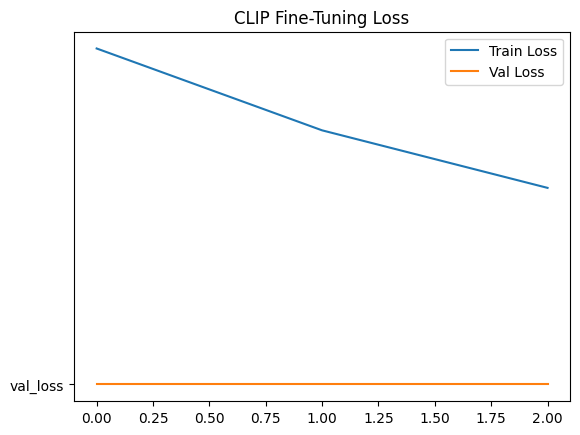

/tmp/ipykernel_624551/1221947276.py:11: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


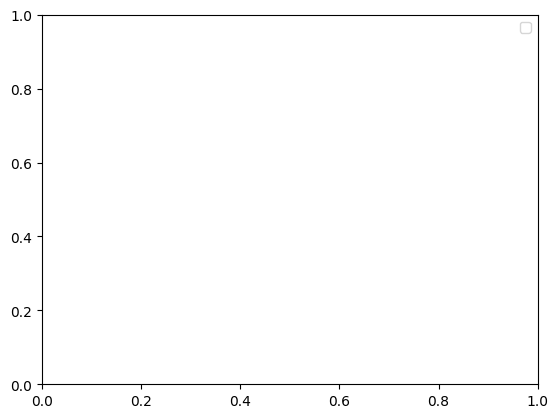

In [82]:
import matplotlib.pyplot as plt

plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.title("CLIP Fine-Tuning Loss")
plt.legend()
plt.show()

# plt.plot(val_accuracies, label="Val Accuracy")
# plt.title("CLIP Val Accuracy")
plt.legend()
plt.show()


In [ ]:
import matplotlib.pyplot as plthj
import numpy as np
import pandas as pd
import os
import torch
import time
from datetime import datetime

def plot_training_metrics(
    train_losses, 
    val_losses, 
    val_accuracies=None, 
    learning_rates=None, 
    save_dir='plots'
):
    """
    Plot training metrics including losses, accuracy, and learning rate.
    
    Args:
        train_losses: List of training losses per epoch
        val_losses: List of validation losses per epoch
        val_accuracies: List of validation accuracies per epoch (optional)
        learning_rates: List of learning rates per epoch (optional)
        save_dir: Directory to save the plots
    """
    # Create directory if it doesn't exist
    os.makedirs(save_dir, exist_ok=True)
    
    # Generate timestamp for unique filenames
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    
    # Set style for plots
    plt.style.use('ggplot')
    
    # Plot losses
    plt.figure(figsize=(10, 6))
    epochs = range(1, len(train_losses) + 1)
    
    plt.plot(epochs, train_losses, 'b-o', label='Training Loss')
    plt.plot(epochs, val_losses, 'r-o', label='Validation Loss')
    
    plt.title('CLIP Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    
    # Save the loss plot
    loss_plot_path = os.path.join(save_dir, f'clip_losses_{timestamp}.png')
    plt.savefig(loss_plot_path, dpi=300, bbox_inches='tight')
    print(f"Loss plot saved to {loss_plot_path}")
    plt.close()
    
    # Plot validation accuracy if provided
    if val_accuracies:
        plt.figure(figsize=(10, 6))
        plt.plot(epochs, val_accuracies, 'g-o')
        plt.title('CLIP Validation Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy (%)')
        plt.grid(True)
        
        # Save the accuracy plot
        acc_plot_path = os.path.join(save_dir, f'clip_accuracy_{timestamp}.png')
        plt.savefig(acc_plot_path, dpi=300, bbox_inches='tight')
        print(f"Accuracy plot saved to {acc_plot_path}")
        plt.close()
    
    # Plot learning rate if provided
    if learning_rates:
        plt.figure(figsize=(10, 6))
        plt.plot(epochs, learning_rates, 'purple', marker='o')
        plt.title('Learning Rate Schedule')
        plt.xlabel('Epochs')
        plt.ylabel('Learning Rate')
        plt.yscale('log')  # Log scale often better for LR visualization
        plt.grid(True)
        
        # Save the learning rate plot
        lr_plot_path = os.path.join(save_dir, f'clip_lr_schedule_{timestamp}.png')
        plt.savefig(lr_plot_path, dpi=300, bbox_inches='tight')
        print(f"Learning rate plot saved to {lr_plot_path}")
        plt.close()
    
    # Combined plot with dual y-axis
    if val_accuracies:
        fig, ax1 = plt.subplots(figsize=(12, 7))
        
        # Loss curves on left y-axis
        ax1.set_xlabel('Epochs')
        ax1.set_ylabel('Loss', color='tab:blue')
        ax1.plot(epochs, train_losses, 'b-o', label='Training Loss')
        ax1.plot(epochs, val_losses, 'r-o', label='Validation Loss')
        ax1.tick_params(axis='y', labelcolor='tab:blue')
        
        # Accuracy curve on right y-axis
        ax2 = ax1.twinx()
        ax2.set_ylabel('Accuracy (%)', color='tab:green')
        ax2.plot(epochs, val_accuracies, 'g-o', label='Validation Accuracy')
        ax2.tick_params(axis='y', labelcolor='tab:green')
        
        # Add legend
        lines1, labels1 = ax1.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax1.legend(lines1 + lines2, labels1 + labels2, loc='center right')
        
        plt.title('CLIP Training Metrics')
        plt.grid(True, alpha=0.3)
        
        # Save the combined plot
        combined_plot_path = os.path.join(save_dir, f'clip_combined_metrics_{timestamp}.png')
        plt.savefig(combined_plot_path, dpi=300, bbox_inches='tight')
        print(f"Combined metrics plot saved to {combined_plot_path}")
        plt.close()


# Updated training function to track and plot metrics
def train_clip_model_with_plots(
    model,
    train_loader,
    val_loader,
    num_epochs=10,
    learning_rate=2e-5,
    weight_decay=0.01,
    scheduler_type="cosine",
    warmup_epochs=1,
    checkpoint_dir="checkpoints",
    plots_dir="plots",
    device=None
):
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Move model to device
    model = model.to(device)
    
    # Create optimizer
    optimizer = torch.optim.AdamW(
        model.parameters(),
        lr=learning_rate,
        weight_decay=weight_decay
    )
    
    # Create scheduler based on type
    scheduler = None
    if scheduler_type == "cosine":
        # Cosine decay from initial lr to near-zero
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
            optimizer, 
            T_max=num_epochs - warmup_epochs,
            eta_min=1e-6
        )
        
        # Optional: Warmup scheduler for first few epochs
        if warmup_epochs > 0:
            warmup_scheduler = torch.optim.lr_scheduler.LinearLR(
                optimizer, 
                start_factor=0.1, 
                end_factor=1.0, 
                total_iters=warmup_epochs
            )
            
    elif scheduler_type == "linear":
        # Linear decay
        scheduler = torch.optim.lr_scheduler.LinearLR(
            optimizer,
            start_factor=1.0,
            end_factor=0.1,
            total_iters=num_epochs
        )
        
    elif scheduler_type == "plateau":
        # Reduce LR when validation loss plateaus
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer,
            mode='min',
            factor=0.5,
            patience=2,
            verbose=True
        )
    
    # Create directories if they don't exist
    os.makedirs(checkpoint_dir, exist_ok=True)
    os.makedirs(plots_dir, exist_ok=True)
    
    # Metrics tracking
    train_losses = []
    val_losses = []
    val_accuracies = []
    learning_rates = []
    
    best_val_acc = 0
    best_model_path = None
    
    # Training loop
    for epoch in range(num_epochs):
        current_lr = optimizer.param_groups[0]['lr']
        learning_rates.append(current_lr)
        
        print(f"\n== Epoch {epoch+1}/{num_epochs} ==")
        print(f"Learning rate: {current_lr:.2e}")
        
        # Training phase
        train_loss, train_time = do_train(
            model,
            train_loader,
            optimizer,
            epoch,
            device,
            scheduler=(warmup_scheduler if epoch < warmup_epochs and warmup_epochs > 0 else None),
            max_grad_norm=1.0
        )
        
        # Evaluation phase
        val_loss, val_acc, val_time = do_eval(model, val_loader, device)
        
        # Record metrics
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc * 100)  # Convert to percentage
        
        # Step the scheduler
        if scheduler_type == "plateau":
            scheduler.step(val_loss)
        elif scheduler is not None and epoch >= warmup_epochs:
            scheduler.step()
        elif warmup_epochs > 0 and epoch < warmup_epochs:
            warmup_scheduler.step()
        
        # Save checkpoint if it's the best model so far
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            checkpoint_path = os.path.join(checkpoint_dir, f"clip_best_model_epoch{epoch+1}.pt")
            
            # Save model state
            torch.save({
                'epoch': epoch + 1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_acc': val_acc,
                'val_loss': val_loss,
                'train_losses': train_losses,
                'val_losses': val_losses,
                'val_accuracies': val_accuracies,
                'learning_rates': learning_rates
            }, checkpoint_path)
            
            best_model_path = checkpoint_path
            print(f"🔥 New best model saved to {checkpoint_path}")
        
        # Plot metrics every few epochs or at the end
        if (epoch + 1) % 5 == 0 or epoch == num_epochs - 1:
            plot_training_metrics(
                train_losses, 
                val_losses, 
                val_accuracies, 
                learning_rates,
                save_dir=plots_dir
            )
    
    # Final plots
    plot_training_metrics(
        train_losses, 
        val_losses, 
        val_accuracies, 
        learning_rates,
        save_dir=plots_dir
    )
    
    # Save training history to CSV
    history_df = pd.DataFrame({
        'epoch': list(range(1, num_epochs + 1)),
        'train_loss': train_losses,
        'val_loss': val_losses,
        'val_accuracy': val_accuracies,
        'learning_rate': learning_rates
    })
    
    history_path = os.path.join(plots_dir, f'training_history_{datetime.now().strftime("%Y%m%d_%H%M%S")}.csv')
    history_df.to_csv(history_path, index=False)
    print(f"Training history saved to {history_path}")
    
    print(f"\n== Training Complete ==")
    print(f"Best validation accuracy: {best_val_acc*100:.2f}%")
    print(f"Best model saved at: {best_model_path}")
    
    return model, best_model_path, history_df


# Example usage with the do_train and do_eval functions from previous code
def do_train(model, train_loader, optimizer, epoch, device, scheduler=None, max_grad_norm=1.0):
    model.train()
    total_loss = 0.0
    start_time = time.time()
    
    for batch_idx, batch in enumerate(train_loader):
        batch = {k: v.to(device) for k, v in batch.items()}
        
        # Forward pass
        outputs = model(**batch, return_loss=True)
        loss = outputs.loss
        
        # Backward pass
        loss.backward()
        
        # Gradient clipping for stability
        if max_grad_norm > 0:
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
            
        optimizer.step()
        optimizer.zero_grad()
        
        total_loss += loss.item()
        
        # Report progress for long epochs
        if batch_idx % 50 == 0:
            print(f"  Batch {batch_idx}/{len(train_loader)} - Loss: {loss.item():.4f}")
    
    train_time = time.time() - start_time
    avg_train_loss = total_loss / len(train_loader)
    
    print(f"✅ Epoch {epoch+1} - Train Loss: {avg_train_loss:.4f} - Time: {train_time:.2f}s")
    return avg_train_loss, train_time

@torch.no_grad()
def do_eval(model, val_loader, device):
    model.eval()
    total_loss = 0.0
    all_preds = []
    all_labels = []
    start_time = time.time()
    
    for batch in val_loader:
        batch = {k: v.to(device) for k, v in batch.items()}
        
        # Get loss
        outputs = model(**batch, return_loss=True)
        loss = outputs.loss
        total_loss += loss.item()
        
        # Get image and text features
        image_embeds = model.get_image_features(pixel_values=batch['pixel_values'])
        text_embeds = model.get_text_features(
            input_ids=batch['input_ids'], 
            attention_mask=batch['attention_mask']
        )
        
        # Normalize
        image_embeds = image_embeds / image_embeds.norm(dim=-1, keepdim=True)
        text_embeds = text_embeds / text_embeds.norm(dim=-1, keepdim=True)
        
        # Compute similarity
        logits = torch.matmul(image_embeds, text_embeds.T) * model.logit_scale.exp()
        
        # Prediction (diagonal elements should be highest)
        preds = torch.argmax(logits, dim=1)
        labels = torch.arange(len(preds)).to(device)
        
        all_preds.extend(preds.cpu().tolist())
        all_labels.extend(labels.cpu().tolist())
    
    val_time = time.time() - start_time
    avg_val_loss = total_loss / len(val_loader)
    val_acc = len([i for i, (p, l) in enumerate(zip(all_preds, all_labels)) if p == l]) / len(all_preds)
    
    print(f"📊 Validation Loss: {avg_val_loss:.4f} - Val_Accuracy: {val_acc*100:.2f}% - Time: {val_time:.2f}s")
    return avg_val_loss, val_acc, val_time


# Example of how to use the plotting functionality
if __name__ == "__main__":
    from transformers import CLIPModel, CLIPProcessor
    
    # Load pre-trained CLIP model and processor
    model_name = "openai/clip-vit-base-patch32"
    model = CLIPModel.from_pretrained(model_name)
    processor = CLIPProcessor.from_pretrained(model_name)
    
    # Prepare your datasets and dataloaders here
    # train_dataset = ...
    # val_dataset = ...
    # train_loader = ...
    # val_loader = ...
    
    # Train the model with plotting
    trained_model, best_model_path, history_df = train_clip_model_with_plots(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        num_epochs=20,
        learning_rate=2e-5,
        scheduler_type="cosine",
        warmup_epochs=2,
        plots_dir="clip_training_plots"
    )
    
    # If you want to plot metrics from a saved checkpoint:
    """
    checkpoint = torch.load('path/to/checkpoint.pt')
    plot_training_metrics(
        checkpoint['train_losses'],
        checkpoint['val_losses'],
        checkpoint['val_accuracies'],
        checkpoint['learning_rates'],
        save_dir='restored_plots'
    )
    """